In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
random.seed(123)
np.random.seed(123)
tf.set_random_seed(123)

In [4]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
soft_targets = np.load(file="soft-targets.npy")

In [6]:
n_epochs = 50
batch_size = 50
num_nodes_h1 = 600 # Before 800
num_nodes_h2 = 600 # Before 800
learning_rate = 0.001

In [7]:
n_batches = len(mnist.train.images) // batch_size

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [9]:
def softmax_with_temperature(logits, temp=1.0, axis=1, name=None):
    logits_with_temp = logits / temp
    _softmax = tf.exp(logits_with_temp) / tf.reduce_sum(tf.exp(logits_with_temp), \
                                                        axis=axis, keep_dims=True)
    return _softmax

In [10]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])
soft_target_ = tf.placeholder(tf.float32, [None, 10])

keep_prob = tf.placeholder(tf.float32)
T = tf.placeholder(tf.float32)

In [11]:
W_h1 = weight_variable([784, num_nodes_h1])
b_h1 = bias_variable([num_nodes_h1])
h1 = tf.nn.relu(tf.matmul(x, W_h1) + b_h1)
h1_drop = tf.nn.dropout(h1, keep_prob)

In [12]:
W_h2 = weight_variable([num_nodes_h1, num_nodes_h2])
b_h2 = bias_variable([num_nodes_h2])
h2 = tf.nn.relu(tf.matmul(h1_drop, W_h2) + b_h2)
h2_drop = tf.nn.dropout(h2, keep_prob)

In [13]:
W_output = tf.Variable(tf.zeros([num_nodes_h2, 10]))
b_output = tf.Variable(tf.zeros([10]))
logits = tf.matmul(h2_drop, W_output) + b_output

In [14]:
y = tf.nn.softmax(logits)
y_soft_target = softmax_with_temperature(logits, temp=T)

In [15]:
loss_hard_target = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])
loss_soft_target = -tf.reduce_sum(soft_target_ * tf.log(y_soft_target), \
                                  reduction_indices=[1])

In [16]:
loss = tf.reduce_mean(\
                      tf.square(T) * loss_hard_target \
                      + tf.square(T) * loss_soft_target)

In [17]:
train_step = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [18]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
saver = tf.train.Saver()

In [20]:
losses = []
accs = []
test_accs = []

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        x_shuffle, y_shuffle, soft_targets_shuffle \
                = shuffle(mnist.train.images, mnist.train.labels, soft_targets)
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            batch_x, batch_y, batch_soft_targets \
                    = x_shuffle[start:end], y_shuffle[start:end], soft_targets_shuffle[start:end]
            sess.run(train_step, feed_dict={
                                            x: batch_x, y_: batch_y, soft_target_:batch_soft_targets, 
                                            keep_prob:0.5, T:2.0})
        train_loss = sess.run(loss, feed_dict={
                                            x: batch_x, y_: batch_y, soft_target_:batch_soft_targets, 
                                            keep_prob:0.5, T:2.0})
        train_accuracy = sess.run(accuracy, feed_dict={
                                            x: batch_x, y_: batch_y, keep_prob:1.0, T:1.0})
        test_accuracy = sess.run(accuracy, feed_dict={
                                            x: mnist.test.images, y_: mnist.test.labels, keep_prob:1.0, T:1.0})
        print("Epoch : %i, Loss : %f, Accuracy: %f, Test accuracy: %f" % (
                epoch+1, train_loss, train_accuracy, test_accuracy))
        saver.save(sess, "model_student", global_step=epoch+1)
        losses.append(train_loss)
        accs.append(train_accuracy)
        test_accs.append(test_accuracy)
    print("... completed!")

Epoch : 1, Loss : 6.967591, Accuracy: 0.880000, Test accuracy: 0.868700
Epoch : 2, Loss : 6.137230, Accuracy: 0.920000, Test accuracy: 0.892300
Epoch : 3, Loss : 5.013751, Accuracy: 0.940000, Test accuracy: 0.904100
Epoch : 4, Loss : 6.543464, Accuracy: 0.940000, Test accuracy: 0.911400
Epoch : 5, Loss : 4.962038, Accuracy: 0.940000, Test accuracy: 0.917300
Epoch : 6, Loss : 5.232879, Accuracy: 0.920000, Test accuracy: 0.918500
Epoch : 7, Loss : 5.688709, Accuracy: 0.900000, Test accuracy: 0.922500
Epoch : 8, Loss : 4.305278, Accuracy: 1.000000, Test accuracy: 0.926200
Epoch : 9, Loss : 4.745485, Accuracy: 0.960000, Test accuracy: 0.927200
Epoch : 10, Loss : 4.607293, Accuracy: 0.940000, Test accuracy: 0.930400
Epoch : 11, Loss : 4.504891, Accuracy: 0.940000, Test accuracy: 0.933100
Epoch : 12, Loss : 7.081215, Accuracy: 0.860000, Test accuracy: 0.934100
Epoch : 13, Loss : 5.432238, Accuracy: 0.900000, Test accuracy: 0.936600
Epoch : 14, Loss : 5.656033, Accuracy: 0.860000, Test accura

In [24]:
! ls model_student*

model_student-46.data-00000-of-00001  model_student-48.meta
model_student-46.index		      model_student-49.data-00000-of-00001
model_student-46.meta		      model_student-49.index
model_student-47.data-00000-of-00001  model_student-49.meta
model_student-47.index		      model_student-50.data-00000-of-00001
model_student-47.meta		      model_student-50.index
model_student-48.data-00000-of-00001  model_student-50.meta
model_student-48.index


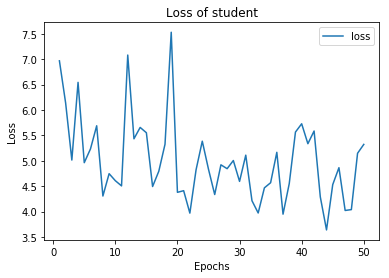

In [22]:
plt.title("Loss of student")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.legend()

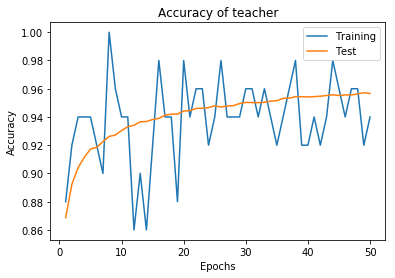

In [23]:
plt.title("Accuracy of teacher")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, len(accs)+1), accs, label='Training')
plt.plot(range(1, len(test_accs)+1), test_accs, label='Test')
plt.legend()

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "model_student-49")
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob:1.0}))

INFO:tensorflow:Restoring parameters from model_student-49
0.9572


In [26]:
np.save("loss_student.npy", np.array(losses))
np.save("acc_student.npy", np.array(accs))
np.save("acc_test_student.npy", np.array(test_accs))

In [27]:
! ls *.npy

acc_student.npy  acc_test_student.npy  loss_student.npy  soft-targets.npy
acc_teacher.npy  acc_test_teacher.npy  loss_teacher.npy
